On 09/19, it is discovered that reshuffling helps a lot. This is to test whether that applies to earlier samples. Conclusion is NO.

In [1]:
# Numpy
import numpy as np
import pandas as pd
import scipy.stats, scipy.interpolate, scipy.spatial

# matplotlib
%matplotlib nbagg
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches

# plotly
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

# Machine learning
import tensorflow as tf
import keras
import sklearn
import sklearn.preprocessing, sklearn.base, sklearn.utils, sklearn.model_selection, sklearn.gaussian_process, sklearn.linear_model
import optunity
import statsmodels.nonparametric.smoothers_lowess

# Various Python tricks and libraries
import re
import requests
import time
import functools
import operator
import collections
from tqdm import tqdm, tqdm_notebook, tnrange
import dill as pickle
import IPython
import gc
import json
from collections import OrderedDict

# Parallel
import joblib
import multiprocessing

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [2]:
plotly.offline.init_notebook_mode(connected=True)

In [3]:
class Minibatch(object):
    '''
    Makes batches from dataframes.
    Executes n_epochs before raising StopIteration.
    Allows manually setting aside a test set, or automatically randomly selecting one.
    Progress bar.
    
    Note: 
    "train set" is preferred to "training set", e.g. train_index, X_train
    "idnex" refer to "iloc", not "loc" in dataframe.

    Variables:
    n_minibatches, i_minibatch
    n_epochs, @property i_epoch
    '''
    
    
    def __init__(self, df, minibatch_size, n_epochs, train_index=None, test_index=None, train_split=None, test_split=None, tqdm=True):
        self.minibatch_size = minibatch_size
        self.n_epochs = n_epochs
        N = len(df)
        all_index = range(N)
        
        # determine train_index and test_index
        # given index
        if train_index and test_index:
            pass
        elif train_index and not test_index:
            test_index = list(set(all_index) - set(train_index))
        elif test_index and not train_index:
            train_index = list(set(all_index) - set(test_index))
        # given split percentage
        elif train_split and test_split:
            train_index = np.random.choice(all_index, int(N * train_split), replace=False)
            remaining_index = list(set(all_index) - set(train_index))
            test_index = np.random.choice(remaining_index, int(N * test_split), replace=False)
        elif train_split and not test_split:
            train_index = np.random.choice(all_index, int(N * train_split), replace=False)
            test_index = list(set(all_index) - set(train_index))
        elif test_split and not train_split:
            test_index = np.random.choice(all_index, int(N * test_split), replace=False)   
            train_index = list(set(all_index) - set(test_index))
        else:
            raise Exception("Either specify index, or specify split.")
                            
        # generate train_df
        self.train_df = df.iloc[train_index]
        self.test_df = df.iloc[test_index]
        self.df = df

        # minibatch counter
        self.i_minibatch = 0
        self.n_minibatches = n_epochs * len(self.train_df) / minibatch_size
        
        if tqdm:
            self.tqdm = tqdm_notebook(total=self.n_minibatches, leave=False)
        
    def minibatch(self):
        if self.i_minibatch > self.n_minibatches:
            self.i_minibatch = 0
            raise StopIteration
        else:
            self.i_minibatch += 1
            
        if getattr(self, 'tqdm', None):
            self.tqdm.update(1)
        
        index = np.random.choice(range(len(self.train_df)), self.minibatch_size, replace=False)
        return self.train_df.iloc[index, :-1].values, self.train_df.iloc[index, -1].values.reshape(-1, 1)
    
    def train_set(self):
        return self.train_df.iloc[:, :-1].values, self.train_df.iloc[:, -1].values.reshape(-1, 1)
    
    def test_set(self):
        return self.test_df.iloc[:, :-1].values, self.test_df.iloc[:, -1].values.reshape(-1, 1)
    
    @property
    def i_epoch(self):
        # the number of epochs
        return float(self.i_minibatch) * self.n_epochs / self.n_minibatches

In [4]:
class BetterYhatLive(object):
    '''
    Plot (i_epoch, r2).
    Plot (y, yhat).
    '''
    
    def __init__(self, smoothen):
        self.fig, (self.ax_decay, self.ax_corr) = plt.subplots(1, 2, figsize=(14, 4.2))
        self.ax_corr.set_aspect('equal', adjustable='datalim')
        self.i_epochs, self.line_decay_train, self.line_decay_test = [], [], []
        self.smoothen = smoothen
        
    def update(self, i_epoch, y_train, yhat_train, y_test, yhat_test):
        self.i_epochs.append(i_epoch)
        self.line_decay_train.append(sklearn.metrics.r2_score(y_train, yhat_train))
        self.line_decay_test.append(sklearn.metrics.r2_score(y_test, yhat_test))
        # smoothen
        if self.smoothen:
            x = range(len(self.line_decay_train))
            smoothline_decay_train = statsmodels.nonparametric.smoothers_lowess.lowess(self.line_decay_train, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
            smoothline_decay_test = statsmodels.nonparametric.smoothers_lowess.lowess(self.line_decay_test, x, is_sorted=True, frac=0.25, it=1, return_sorted=False)
        else:
            smoothline_decay_train = self.line_decay_train
            smoothline_decay_test = self.line_decay_test
        #
        label_train = '$r^2_{train}$=%.2f'%self.line_decay_train[-1]
        label_test = '$r^2_{test}$=%.2f'%self.line_decay_test[-1]
        #
        self.ax_decay.clear()
        self.ax_decay.plot(self.i_epochs, smoothline_decay_train, label=label_train)
        self.ax_decay.plot(self.i_epochs, smoothline_decay_test, label=label_test)
        self.ax_decay.legend(loc='best')
        #
        self.ax_corr.clear()
        self.ax_corr.set_aspect('equal', adjustable='datalim')
        self.ax_corr.scatter(y_train, yhat_train, color='green', s=1, alpha=0.2, label='train')
        self.ax_corr.scatter(y_test, yhat_test, color='red', s=1, alpha=0.2, label='test')
        self.ax_corr.legend(loc='best')
        #
        self.fig.canvas.draw()

In [5]:
class LambdaGraph(object):
    
    def __init__(self):
        self.bs = OrderedDict()
        
    def add(self, b, label): # b is a BetterYhatLive instance
        self.bs[label] = np.float32(zip(b.i_epochs, b.line_decay_train, b.line_decay_test))
        
    def draw(self):
        print """
        traces = [
            go.Scatter(x = b[:, 1], y = b[:, 2], mode = 'markers', name = label)
            for label, b in l.bs.iteritems()
        ]
        py.iplot(traces, filename='threshold_errors')"""

In [ ]:
# Boilerplate for plotting a dataframe. Do not attempt a function.
# data = [
#     go.Scatter(x = df.index, y = df.loc[:, column], mode = 'markers+lines', name = column) 
#     for column in df.columns
# ]
# py.iplot(data, filename='threshold_errors')   

# 准备$\hat{\text{wait}_i}, \text{nodes}_i, \sum_{j\in S/Q_i}\text{nodes}_j, \text{eta}_i, \sum_{j\in S/Q_i}\text{eta}_j$

读logfile，使之compatible with逻辑定义。

In [6]:
def read_log():
    jobs = pd.read_csv(filepath_or_buffer='ml_queue.nanaimo.20170101-20180704.log', sep='\s+', header='infer', skiprows=[1], na_values=['UNLIMITED','Unknown']).dropna()

    jobs.loc[:, 'nodes'] = pd.to_numeric(jobs.loc[:, 'NNodes'].copy(), errors='coerce', downcast='integer')
    
    # job_name not implemented

    jobs.loc[:, 'Timelimit'] = jobs.loc[:, 'Timelimit'].copy().str.replace('-','day ')
    jobs.loc[:, 'eta'] = pd.to_timedelta(jobs.loc[:, 'Timelimit'].copy(), errors='coerce') / pd.Timedelta('1day')

    jobs.loc[:, 'submit'] = pd.to_datetime(jobs.loc[:, 'Submit'].copy(), errors='coerce')
    
    jobs.loc[:, 'begin'] = pd.to_datetime(jobs.loc[:, 'Start'].copy(), errors='coerce')
    
    jobs.loc[:, 'end'] = pd.to_datetime(jobs.loc[:, 'End'].copy(), errors='coerce')
    
    jobs.loc[:, 'user'] = jobs.loc[:, 'User'].copy() # uid not implemented
    
    # subfile not implemented
    
    jobs.loc[:, 'state'] = jobs.loc[:, 'State'].copy() # scancelled not implemented
    
    jobs.loc[:, 'wait'] = (jobs.begin - jobs.submit).values / pd.Timedelta('1h')

    jobs = jobs.dropna()
    
    jobs = jobs.drop(columns=['User', 'NNodes', 'Timelimit', 'Submit', 'Start', 'End', 'State'])
    
    return jobs

In [7]:
jobs = read_log()

去掉did_not_wait

In [8]:
def SQ(i):
    # S: in service. Q: wait queue.
    
    if i < 100:
        raise Exception
    
    j = jobs.loc[i]
    
    S = jobs.loc[
        np.logical_and.reduce([
            jobs.begin < j.submit, 
            jobs.end >= j.submit
        ])
    ]
    
    Q = jobs.loc[
        np.logical_and.reduce([
            jobs.submit < j.submit, 
            jobs.begin >= j.submit
        ])
    ]
    
    return S, Q

In [9]:
def should_not_wait(i, C):
    S, Q = SQ(i)
    return S.nodes.sum() + Q.nodes.sum() + jobs.loc[i].nodes <= C

C = 32

valid_indices = [_ for _ in jobs.index if _>100]

array_should_not_wait = multiprocessing.Pool(processes=20).map(
    functools.partial(should_not_wait, C=C),
    valid_indices
)
jobs.loc[valid_indices, 'should_not_wait'] = array_should_not_wait

Process PoolWorker-16:
Process PoolWorker-11:
Process PoolWorker-19:
Process PoolWorker-12:
Process PoolWorker-20:
Traceback (most recent call last):
Process PoolWorker-10:
Process PoolWorker-14:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-9:
Process PoolWorker-3:
    self.run()
Process PoolWorker-18:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-5:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-15:
Traceback (most recent call last):
  File "/usr/lib/pyt

    racquire()
    racquire()
    self._target(*self._args, **self._kwargs)
    racquire()
    task = get()
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    racquire()
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
KeyboardInterrupt
    task = get()
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    task = get()
    racquire()
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    task = get()
KeyboardInterrupt
    racquire()
    racquire()
    racquire()
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    racquire()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    r

取sample；去掉CANCELLED+

In [10]:
def sample(i):
    
    if i < 100:
        raise Exception
        
    if jobs.loc[i, 'should_not_wait']:
        return None
    
    if jobs.loc[i, 'state'] == 'CANCELLED+':
        return None
    
    S, Q = SQ(i)

    return [
        i,
        jobs.loc[i, 'nodes'],
        S.nodes.sum(),
        Q.nodes.sum(),
        jobs.loc[i, 'eta'],
        S.eta.sum(),
        Q.eta.sum(),
        jobs.loc[i, 'wait']
    ]

In [11]:
valid_indices = [_ for _ in jobs.index if _>100]

array_samples = multiprocessing.Pool(processes=20).map(sample, valid_indices)

array_samples = [_ for _ in array_samples if _ is not None]

samples = pd.DataFrame(array_samples, columns=['i', 'nodes_i', 'sum_Si nodes_j', 'sum_Qi nodes_j', 'eta_i', 'sum_Si eta_j', 'sum_Qi eta_j', 'wait_i'])
samples = samples.set_index('i')

Process PoolWorker-25:
Process PoolWorker-40:
Process PoolWorker-37:
Process PoolWorker-24:
Process PoolWorker-34:
Process PoolWorker-33:
Process PoolWorker-28:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-29:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
    self.run()
Traceback (most recent call last):
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootst

    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
KeyboardInterrupt
    task = get()
    racquire()
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
    task = get()
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    racquire()
    task = get()
    return recv()
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
KeyboardInterrupt
    racquire()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py",

去掉outlier.

In [12]:
samples = samples[samples.wait_i < samples.wait_i.quantile(q=0.97)].copy()

归一化.

In [13]:
samples_normalized = sklearn.preprocessing.StandardScaler().fit_transform(samples)
samples_unique = np.unique(samples_normalized, axis=0)
samples_unique = pd.DataFrame(samples_unique, columns=samples.columns)

# 做线性拟合，以寻找合适的Range.

In [31]:
lb = 9000
ub = 11000

m = Minibatch(samples_unique, minibatch_size=32, n_epochs=1, train_index=range(lb), test_index=range(lb, ub), tqdm=False)

regr = sklearn.linear_model.LinearRegression()
X_train, y_train = m.train_set()
regr.fit(X_train, y_train)
yhat_train = regr.predict(X_train)
r2_train = regr.score(X_train, y_train)

X_test, y_test = m.test_set()
yhat_test = regr.predict(X_test)
r2_test = regr.score(X_test, y_test)

In [32]:
r2_train

0.36626849361294667

In [33]:
r2_test

0.07977019925089646

In [34]:
data = [
    go.Scatter(x = y_train, y = yhat_train, mode = 'markers', name = 'train'),
    go.Scatter(x = y_test, y = yhat_test, mode = 'markers', name = 'test'),
]
py.iplot(data, filename='ml_queue_0805B.sec2.fig1')   

# ML：求函数$E\hat{\text{wait}_i}\left|\text{nodes}_i, \sum_{j\in S/Q_i}\text{nodes}_j, \text{eta}_i, \sum_{j\in S/Q_i}\text{eta}_j\right.$的拟合

In [14]:
l = LambdaGraph()

In [17]:
lb = 9000
ub = 11000

HBox(children=(IntProgress(value=0, max=72000), HTML(value=u'')))

<IPython.core.display.Javascript object>


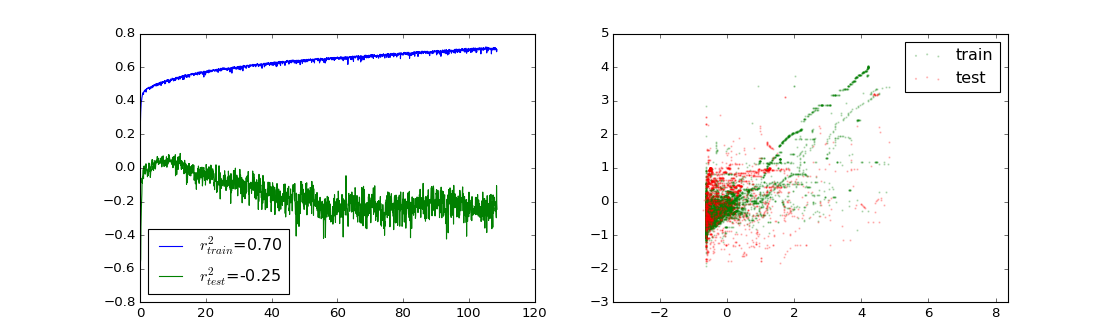

KeyboardInterrupt: 

In [18]:
minibatch_size = 32
n_epochs = 256
ns_units = [25, 25]
lr = 1E-3

# Graph
tf.reset_default_graph()

X = tf.placeholder(name="X", dtype=tf.float32, shape=[None, 6])

h = X
for n_units in ns_units:
    h = tf.layers.dense(h, units=n_units, activation=tf.nn.elu)
h = tf.layers.dense(h, units=1, activation=None)
yhat = h

y = tf.placeholder(name="y", dtype=tf.float32, shape=[None, 1])

loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

# Session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

m = Minibatch(samples_unique, minibatch_size, n_epochs, train_index=range(lb), test_index=range(lb, ub))
b = BetterYhatLive(smoothen=False)
while True:
    try:
        _X, _y = m.minibatch()
        sess.run(train_op, feed_dict = {X: _X, y: _y})
        
        if m.i_minibatch % 20 == 0:
            X_train, y_train = m.train_set()
            yhat_train = sess.run(yhat, feed_dict = {X: X_train})
            X_test, y_test = m.test_set()
            yhat_test = sess.run(yhat, feed_dict = {X: X_test}) 
            b.update(m.i_epoch, y_train, yhat_train, y_test, yhat_test)
    except StopIteration:
        break

sess.close()

In [70]:
l.add(b, label="100-50-25, Adam 0.001, mb256")

In [75]:
traces = [
    go.Scatter(x = b[:, 1], y = b[:, 2], mode = 'markers', name = label)
    for label, b in l.bs.iteritems()
]
py.iplot(traces, filename='ml_queue_0805B.sec3.fig1')

# Trash

In [74]:
myorder = [
'100-100, Adam 0.001, mb256',
'100-50-25, Adam 0.001, mb256',
'45-45, Adam 0.001, mb256',
'25-25, Adam 0.001, mb256',
'15-5, Adam 0.001, mb256',
'5-5, Adam 0.001, mb256',
'2-4-4-2, Adam 0.001, mb256',
'1, Adam 0.001, mb256']

bs = OrderedDict(
    (k, l.bs[k]) for k in myorder
)

l.bs = bs